In [1]:
import grid2op
import numpy as np
from lightsim2grid import LightSimBackend
from grid2op.Parameters import Parameters
from superposition_theorem import *
param = Parameters()
param.ENV_DC = True
param.MAX_LINE_STATUS_CHANGED = 99999
param.MAX_SUB_CHANGED = 99999
#backend=LightSimBackend()
env = grid2op.make("l2rpn_case14_sandbox", param=param)#,backend=backend)


In [2]:
import sys
paths=[i for i in sys.path]


for path in paths:
    sys.path.append(path)

# compute the A matrix that defines the delta

$$\delta_{i,j} = \frac{F_j^{i} - F_j}{F_i}$$

with:
- $\delta_{i,j}$ : "le coefficient de report"
- $F_k$: the active flow on line `k`
- $F_j^{i}$: the flow on line j if the line i is disconnected

We are interested, given all the $\delta_{i,j}$ to compute the $\delta_{\{i,j,k, ...\}, m}$ which are the flows on line `m` when the lines $\{i,j,k, ...\}$ are disconnected

In [3]:
_ = env.reset()
#with env.copy() as tmp_env_init:
init_obs, *_ = env.simulate(env.action_space())
F = 1. * init_obs.p_or

In [4]:
init_obs

In [5]:
all_flows = np.zeros((env.n_line, env.n_line))
for l_id in range(env.n_line):
    #with env.copy() as tmp_env:
    obs, *_ = env.simulate(env.action_space({"set_line_status": [(l_id, -1)]}))
    all_flows[l_id, :] = obs.p_or

In [6]:
A = (all_flows - F) / F.reshape(-1, 1)

In [7]:
F

array([ 3.8583591e+01,  3.7616409e+01,  2.2565678e+01,  4.1696144e+01,
        3.5121765e+01,  1.6865681e+01, -2.9562853e+01,  6.4211507e+00,
        7.0682087e+00,  1.6285961e+01,  5.7788496e+00,  9.5458307e+00,
       -3.0211506e+00,  1.5682089e+00,  5.2541695e+00,  2.7484486e+01,
        1.6040195e+01,  3.6275322e+01, -1.1102230e-14, -2.7484486e+01],
      dtype=float32)

In [8]:
A[3][3]

-1.0

In [9]:
init_obs.p_or[2] + A[1, 2] * init_obs.p_or[1]

28.917064666748047

In [10]:
all_flows[1, 2]

28.917064666748047

In [11]:
all_flows[1]

array([ 76.19999695,   0.        ,  28.91706467,  54.98823929,
        53.09469223,  23.21706772, -11.00502491,   5.76739502,
         6.9721899 ,  15.95008183,   6.43260527,   9.9777298 ,
        -2.36739492,   1.47218966,   4.82227087,  28.17004204,
        16.44029236,  35.18966675,   0.        , -28.17004204])

In [12]:
env.name_line

array(['0_1_0', '0_4_1', '1_2_2', '1_3_3', '1_4_4', '2_3_5', '3_4_6',
       '5_10_7', '5_11_8', '5_12_9', '8_9_10', '8_13_11', '9_10_12',
       '11_12_13', '12_13_14', '3_6_15', '3_8_16', '4_5_17', '6_7_18',
       '6_8_19'], dtype='<U8')

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_700/1957509643.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


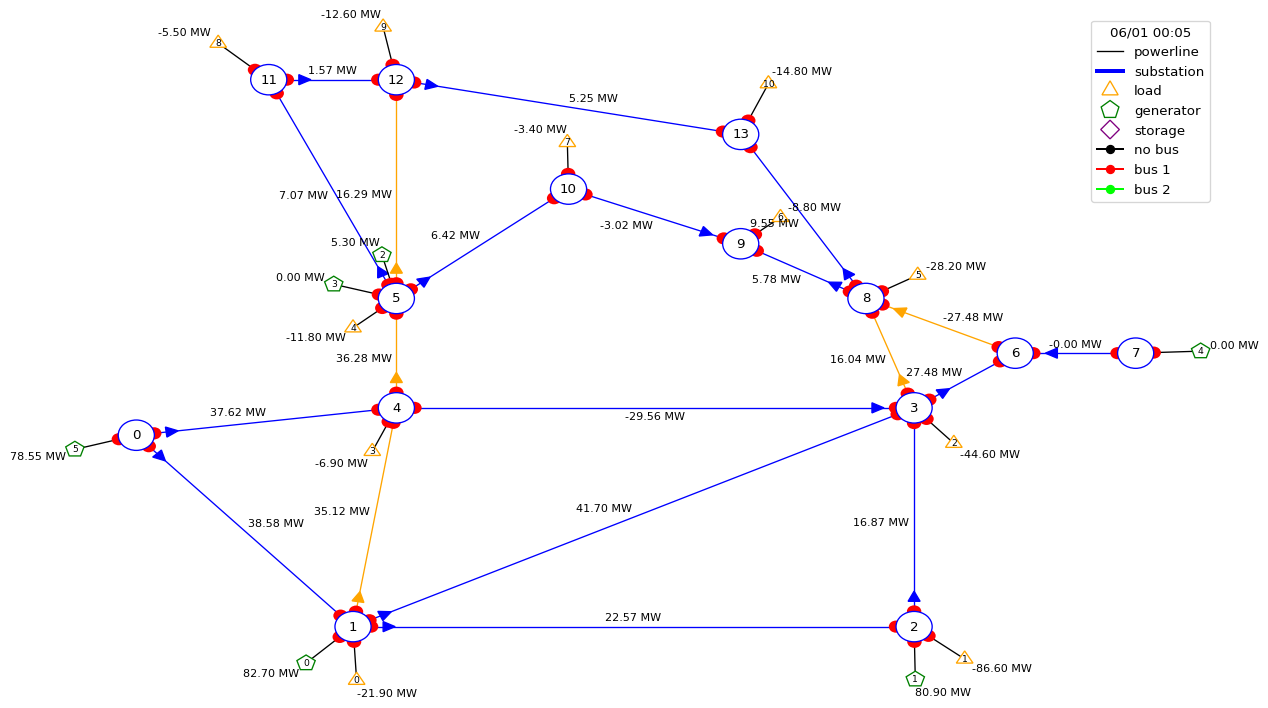

In [13]:
from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_obs(init_obs,line_info="p")
fig.show()


In [14]:
init_obs.p_or

array([ 3.8583591e+01,  3.7616409e+01,  2.2565678e+01,  4.1696144e+01,
        3.5121765e+01,  1.6865681e+01, -2.9562853e+01,  6.4211507e+00,
        7.0682087e+00,  1.6285961e+01,  5.7788496e+00,  9.5458307e+00,
       -3.0211506e+00,  1.5682089e+00,  5.2541695e+00,  2.7484486e+01,
        1.6040195e+01,  3.6275322e+01, -1.1102230e-14, -2.7484486e+01],
      dtype=float32)

In [15]:
id_l1=3
id_l2=7
id_l3=0
#with env.copy() as tmp_env:
obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))

In [16]:
def get_reconnection_LODF(ils_connect,env):
    
    n_lines=env.n_line
    n_lines_connect=len(ils_connect)
    reconnection_LODF=np.zeros((n_lines,n_lines_connect))
    
    
    obs_all_disconnected, *_ = env.simulate(env.action_space({"set_line_status": [(ilj, -1) for ilj in ils_connect]}))
    p_obs_all_disconnected=obs_all_disconnected.p_or
    
    for i,il in enumerate(ils_connect):
        print("line "+str(il)+" is connected")
        obs_connect_l, *_ = env.simulate(env.action_space({"set_line_status": [(ilj, -1) for ilj in ils_connect if ilj!=il]}))
        p_obs_connect_l=obs_connect_l.p_or
        reconnection_LODF[:,i]=(p_obs_all_disconnected-p_obs_connect_l)/p_obs_connect_l[il]
    
    return reconnection_LODF
    
    

In [17]:
def get_delta_theta_line(obs,id_line):
    theta_or=obs.theta_or
    theta_ex=obs.theta_ex

    sub_l_ex=obs.line_ex_to_subid[id_line]
    sub_l_or=obs.line_or_to_subid[id_line]
    lines_sub_or_l=list(obs.get_obj_connect_to(substation_id=sub_l_or)['lines_or_id'])+list(obs.get_obj_connect_to(substation_id=sub_l_or)['lines_ex_id'])
    lines_sub_ex_l=list(obs.get_obj_connect_to(substation_id=sub_l_ex)['lines_or_id'])+list(obs.get_obj_connect_to(substation_id=sub_l_ex)['lines_ex_id'])

    #print(id_line)
    #print(lines_sub_or_l)
    #print(lines_sub_ex_l)
    theta_or_l=0.
    #for ids of thetas, cf previous section where we identified those
    thetas_or_l=np.append(theta_or[obs.get_obj_connect_to(substation_id=sub_l_or)['lines_or_id']],
                          theta_ex[obs.get_obj_connect_to(substation_id=sub_l_or)['lines_ex_id']])
    thetas_or_l=thetas_or_l[thetas_or_l!=0]
    #print(thetas_or_l)

    if len(thetas_or_l)!=0:
        if (np.sum(np.abs(thetas_or_l))!=0):
            thetas_or_l=thetas_or_l[thetas_or_l!=0]
        theta_or_l=np.median(thetas_or_l)
    
    theta_ex_l=0.
    thetas_ex_l=np.append(theta_or[obs.get_obj_connect_to(substation_id=sub_l_ex)['lines_or_id']],
                    theta_ex[obs.get_obj_connect_to(substation_id=sub_l_ex)['lines_ex_id']])
    thetas_ex_l=thetas_ex_l[thetas_ex_l!=0]
    #print(thetas_ex_l)
    
    if len(thetas_ex_l)!=0:
        if (np.sum(np.abs(theta_ex_l))!=0):
            theta_ex_l=theta_ex_l[theta_ex_l!=0]
        theta_ex_l=np.median(thetas_ex_l)
    delta_theta_l=theta_or_l-theta_ex_l
    #delta_theta_l2=theta_or[8]-theta_ex[12]
    #print(delta_theta_l)
    
    return delta_theta_l#/360*2*3.14159 #use PI number with enough significant digits!!


In [18]:
def get_equivalent_delta_theta(obs,sub_or,sub_ex):
    
    #lines_sub_or_l3=list(obs.get_obj_connect_to(substation_id=sub_or)['lines_or_id'])+list(obs.get_obj_connect_to(substation_id=sub_or)['lines_ex_id'])
    #lines_sub_ex_l3=list(obs.get_obj_connect_to(substation_id=sub_ex)['lines_or_id'])+list(obs.get_obj_connect_to(substation_id=sub_ex)['lines_ex_id'])
    
    theta_or_l=0
    theta_ex_l=0
    
    theta_or=obs.theta_or
    theta_ex=obs.theta_ex
    
    theta_or_l_sub=list(theta_or[list(obs.get_obj_connect_to(substation_id=sub_or)['lines_or_id'])])
    theta_or_l_sub+=list(theta_ex[list(obs.get_obj_connect_to(substation_id=sub_or)['lines_ex_id'])])
    
    #print(theta_or_l_sub)
    if 0.0 in theta_or_l_sub:
        theta_or_l_sub.remove(0.0)
    
    if (len(theta_or_l_sub)>=1):
        theta_or_l=np.median(theta_or_l_sub)
    
        
    theta_ex_l_sub=list(theta_or[list(obs.get_obj_connect_to(substation_id=sub_ex)['lines_or_id'])])
    theta_ex_l_sub+=list(theta_ex[list(obs.get_obj_connect_to(substation_id=sub_ex)['lines_ex_id'])])
    
    #print(theta_ex_l_sub)
    if 0.0 in theta_ex_l_sub:
        theta_ex_l_sub.remove(0.0)
    if (len(theta_ex_l_sub)>=1):
        theta_ex_l=np.median(theta_ex_l_sub)
    
    #print(theta_or_l)
    #print(theta_ex_l)
    
    return (theta_or_l-theta_ex_l)#/360*2*3.14159

In [19]:
def get_betas_coeff_N2_reconnect(id_l1,id_l2,env):
    init_obs, *_ = env.simulate(env.action_space())
    obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))
    obs_disconnect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))
    obs_disconnect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))
    
    expected_betas=[init_obs.p_or[id_l1]/obs_disconnect_l2.p_or[id_l1],init_obs.p_or[id_l2]/obs_disconnect_l1.p_or[id_l2]]
    print("expected_betas :"+str(expected_betas))
    
    sub_l1_ex=init_obs.line_ex_to_subid[id_l1]
    sub_l1_or=init_obs.line_or_to_subid[id_l1]

    sub_l2_ex=init_obs.line_ex_to_subid[id_l2]
    sub_l2_or=init_obs.line_or_to_subid[id_l2]
    
    a=[[1,1-get_delta_theta_line(obs_disconnect_l1,id_l1)/get_delta_theta_line(obs_disconnected_l1_l2,id_l1)],
        [1-get_delta_theta_line(obs_disconnect_l2,id_l2)/get_delta_theta_line(obs_disconnected_l1_l2,id_l2),1]
    ]
    b=[1,1]

    
    print(a)
    print(b)

    betas=np.linalg.solve(a,b)
    
    print("computed betas: "+str(betas))
    return betas
    

In [48]:
#def get_betas_coeff_reconnect(id_l1,id_l2,env):
def get_betas_coeff_N_reconnect(idls,obs_connect_idls,obs_all_disconected,init_obs=None):
    
    if init_obs is not None:
        #expected_betas=[init_obs.p_or[id_l]/obs_connect_idls[i].p_or[id_l] for i,id_l in enumerate(idls)]
        expected_betas=[get_delta_theta_line(init_obs,id_l)/get_delta_theta_line(obs_connect_idls[i],id_l) for i,id_l in enumerate(idls)]
        print("expected_betas :"+str(expected_betas))
    
    #sub_l_ors=[init_obs.line_or_to_subid[idl] for idl in idls]
    #sub_l_exs=[init_obs.line_ex_to_subid[idl] for idl in idls]

    n_lines_connect=len(idls)
    a=np.zeros((n_lines_connect,n_lines_connect))
    b=np.zeros(n_lines_connect)
    
    #    a=[[1,1-get_delta_theta_line(obs_disconnect_l1,id_l1)/get_delta_theta_line(obs_disconnected_l1_l2,id_l1)],
    #    [1-get_delta_theta_line(obs_disconnect_l2,id_l2)/get_delta_theta_line(obs_disconnected_l1_l2,id_l2),1]
    #]
    a=np.array([[1-get_delta_theta_line(obs_connect_idls[i],idls[j])/get_delta_theta_line(obs_all_disconected,idls[j])\
        for i in range(len(idls))] for j in range(len(idls))])
    
    np.fill_diagonal(a, 1)
       
    b=np.ones(n_lines_connect)
    
        
    print(a)
    print(b)

    betas=np.linalg.solve(a,b)
    
    print("computed betas: "+str(betas))
    return betas
    
    

In [49]:
id_l1=1#3#2#3
id_l2=2#7#4#7
print(id_l1)
print(id_l2)

init_obs, *_ = env.simulate(env.action_space())
obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))
obs_disconnect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))
obs_disconnect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))

betas=get_betas_coeff_N2_reconnect(id_l1,id_l2,env)
#get_betas_coeff_reconnect(id_l1,id_l2,init_obs,obs_disconnected_l1_l2,obs_disconnect_l1,obs_disconnect_l2)


1
2
expected_betas :[0.88922304, 0.7803585]
[[1, 0.14195656778802213], [0.24700379371643066, 1]]
[1, 1]
computed betas: [0.88922298 0.78035855]


In [50]:
id_l1=1#3#2#3
id_l2=2#7#4#7
print(id_l1)
print(id_l2)

init_obs, *_ = env.simulate(env.action_space())
obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))
obs_connect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))
obs_connect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))

obs_connect_idls=[obs_connect_l1,obs_connect_l2]
idls=[id_l1,id_l2]

#betas=get_betas_coeff_reconnect(id_l1,id_l2,env)
#get_betas_coeff_reconnect(id_l1,id_l2,init_obs,obs_disconnected_l1_l2,obs_disconnect_l1,obs_disconnect_l2)

betas=get_betas_coeff_N_reconnect(idls,obs_connect_idls,obs_disconnected_l1_l2,init_obs)

1
2
expected_betas :[0.8892229837633067, 0.7803585]
[[1.         0.14195657]
 [0.24700379 1.        ]]
[1. 1.]
computed betas: [0.88922298 0.78035855]


In [51]:
init_obs, *_ = env.simulate(env.action_space())
obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))
obs_disconnect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))
obs_disconnect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))

p_or_all_reconnected=init_obs.p_or

obs_reco_l1=obs_disconnect_l2
obs_reco_l2=obs_disconnect_l1
p_or_all_reconnected_computed=betas[0]*obs_reco_l1.p_or+betas[1]*obs_reco_l2.p_or+\
    (1-np.sum(betas))*obs_disconnected_l1_l2.p_or

print(p_or_all_reconnected)
print(p_or_all_reconnected_computed)

assert(np.all((np.round(p_or_all_reconnected-p_or_all_reconnected_computed,5)==0.0)))

[ 3.8583591e+01  3.7616409e+01  2.2565678e+01  4.1696144e+01
  3.5121765e+01  1.6865681e+01 -2.9562853e+01  6.4211507e+00
  7.0682087e+00  1.6285961e+01  5.7788496e+00  9.5458307e+00
 -3.0211506e+00  1.5682089e+00  5.2541695e+00  2.7484486e+01
  1.6040195e+01  3.6275322e+01 -1.1102230e-14 -2.7484486e+01]
[ 38.583588   37.61641    22.56568    41.69614    35.12176    16.865683
 -29.56285     6.4211507   7.0682087  16.285961    5.77885     9.545832
  -3.02115     1.568209    5.2541695  27.484486   16.040194   36.275322
   0.        -27.484486 ]


In [52]:
id_l1=1#3#2#3
id_l2=2#7#4#7
id_l3=7#7#4#7
print(id_l1)
print(id_l2)
print(id_l3)

init_obs, *_ = env.simulate(env.action_space())
obs_disconnected_l1_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l3, -1)]}))
obs_connect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l3, -1)]}))
obs_connect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1),(id_l3, -1)]}))
obs_connect_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))

obs_connect_idls=[obs_connect_l1,obs_connect_l2,obs_connect_l3]
idls=[id_l1,id_l2,id_l3]

#betas=get_betas_coeff_reconnect(id_l1,id_l2,env)
#get_betas_coeff_reconnect(id_l1,id_l2,init_obs,obs_disconnected_l1_l2,obs_disconnect_l1,obs_disconnect_l2)

betas=get_betas_coeff_N_reconnect(idls,obs_connect_idls,obs_disconnected_l1_l2_l3,init_obs)


1
2
7
expected_betas :[0.8935199916189367, 0.7765548, 1.0352491]
[[ 1.          0.14296849 -0.0043883 ]
 [ 0.24399954  1.          0.00524205]
 [-0.10071743  0.07049596  1.        ]]
[1. 1. 1.]
computed betas: [0.89352013 0.77655467 1.03524908]


In [53]:
p_or_all_reconnected=init_obs.p_or

p_or_all_reconnected_computed=betas[0]*obs_connect_l1.p_or+betas[1]*obs_connect_l2.p_or+betas[2]*obs_connect_l3.p_or+\
    (1-np.sum(betas))*obs_disconnected_l1_l2_l3.p_or

print(p_or_all_reconnected)
print(p_or_all_reconnected_computed)

assert(np.all((np.round(p_or_all_reconnected-p_or_all_reconnected_computed,4)==0.0)))

[ 3.8583591e+01  3.7616409e+01  2.2565678e+01  4.1696144e+01
  3.5121765e+01  1.6865681e+01 -2.9562853e+01  6.4211507e+00
  7.0682087e+00  1.6285961e+01  5.7788496e+00  9.5458307e+00
 -3.0211506e+00  1.5682089e+00  5.2541695e+00  2.7484486e+01
  1.6040195e+01  3.6275322e+01 -1.1102230e-14 -2.7484486e+01]
[ 3.8583588e+01  3.7616413e+01  2.2565672e+01  4.1696152e+01
  3.5121765e+01  1.6865677e+01 -2.9562862e+01  6.4211464e+00
  7.0682096e+00  1.6285965e+01  5.7788525e+00  9.5458279e+00
 -3.0211468e+00  1.5682087e+00  5.2541704e+00  2.7484489e+01
  1.6040195e+01  3.6275311e+01 -9.9200662e-15 -2.7484489e+01]


In [54]:
id_l1=1#3#2#3
id_l2=2#7#4#7
id_l3=7#7#4#7
id_l4=4
print(id_l1)
print(id_l2)
print(id_l3)

init_obs, *_ = env.simulate(env.action_space())
obs_disconnected_l1_l2_l3_l4, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l3, -1),(id_l4, -1)]}))
obs_connect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l3, -1),(id_l4, -1)]}))
obs_connect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1),(id_l3, -1),(id_l4, -1)]}))
obs_connect_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l4, -1)]}))
obs_connect_l4, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l3, -1)]}))

obs_connect_idls=[obs_connect_l1,obs_connect_l2,obs_connect_l3,obs_connect_l4]
idls=[id_l1,id_l2,id_l3,id_l4]

#betas=get_betas_coeff_reconnect(id_l1,id_l2,env)
#get_betas_coeff_reconnect(id_l1,id_l2,init_obs,obs_disconnected_l1_l2,obs_disconnect_l1,obs_disconnect_l2)

betas=get_betas_coeff_N_reconnect(idls,obs_connect_idls,obs_disconnected_l1_l2_l3_l4,init_obs)


1
2
7
expected_betas :[0.6214907553240204, 0.48966047, 1.6051482, 0.5340384]
[[ 1.          0.26895245 -0.00335727  0.47225561]
 [ 0.42465806  1.          0.          0.46142447]
 [-0.50354838  0.          1.         -0.54714537]
 [ 0.51086646  0.31613094 -0.00394619  1.        ]]
[1. 1. 1. 1.]
computed betas: [0.62149082 0.48966045 1.60514743 0.53403857]


In [55]:
p_or_all_reconnected=init_obs.p_or

p_or_all_reconnected_computed=betas[0]*obs_connect_l1.p_or+betas[1]*obs_connect_l2.p_or+betas[2]*obs_connect_l3.p_or+\
    betas[3]*obs_connect_l4.p_or+(1-np.sum(betas))*obs_disconnected_l1_l2_l3_l4.p_or

print(p_or_all_reconnected)
print(p_or_all_reconnected_computed)

assert(np.all((np.round(p_or_all_reconnected-p_or_all_reconnected_computed,4)==0.0)))


[ 3.8583591e+01  3.7616409e+01  2.2565678e+01  4.1696144e+01
  3.5121765e+01  1.6865681e+01 -2.9562853e+01  6.4211507e+00
  7.0682087e+00  1.6285961e+01  5.7788496e+00  9.5458307e+00
 -3.0211506e+00  1.5682089e+00  5.2541695e+00  2.7484486e+01
  1.6040195e+01  3.6275322e+01 -1.1102230e-14 -2.7484486e+01]
[ 3.8583588e+01  3.7616413e+01  2.2565676e+01  4.1696167e+01
  3.5121777e+01  1.6865677e+01 -2.9562866e+01  6.4211493e+00
  7.0682106e+00  1.6285961e+01  5.7788506e+00  9.5458279e+00
 -3.0211501e+00  1.5682089e+00  5.2541704e+00  2.7484482e+01
  1.6040195e+01  3.6275322e+01  1.4326092e-14 -2.7484482e+01]


# checking that the rule with delta_thetas also apply to line connections + the combination of disconnections and connections

get_delta_theta_line(obs_disconnected_l1_l2_l3,id_l1)=beta_l1 * get_delta_theta_line(obs_disconnect_l1,id_l1)

and same for l2 and l3

In [56]:
#checking relationship between NK virtual flow and delta_theta ratio

init_obs, *_ = env.simulate(env.action_space())
obs_disconnected_l1_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l3, -1)]}))
obs_disconnect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))
obs_disconnect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))
obs_disconnect_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l3, -1)]}))


get_Virtual_Flows_NK(init_obs.p_or,A,[id_l1,id_l2,id_l3])

print(get_delta_theta_line(obs_disconnected_l1_l2_l3,id_l1)/get_delta_theta_line(obs_disconnect_l1,id_l1))

init_obs, *_ = env.simulate(env.action_space())
init_obs.p_or[id_l1]*1.160350 #delta ratio, we get the virtuak flow NK for line 1

In [65]:
id_l1=1#3#2#3
id_l2=2#7#4#7
id_l3=7#7#4#7
id_l4=4
print(id_l1)
print(id_l2)
print(id_l3)

init_obs, *_ = env.simulate(env.action_space())
obs_disconnected_l1_l2_l3_l4, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l3, -1),(id_l4, -1)]}))
#we start with l1 and l2 connected, and target to disconnect l3 and l4 and reconnect l1 and l2
obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))
obs_disconnected_l3_l4, *_ = env.simulate(env.action_space({"set_line_status": [(id_l3, -1),(id_l4, -1)]}))

#we disconnect l3, l4
obs_disconnected_l1_l2_l3, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l3, -1)]}))
obs_disconnected_l1_l2_l4, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1),(id_l4, -1)]}))

#we reconnect l1, l2
obs_reco_l1, *_=env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))
obs_reco_l2, *_=env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))

idls=[id_l1,id_l2,id_l3,id_l4]
obs_connect_idls=[obs_reco_l1,obs_reco_l2,obs_disconnected_l1_l2_l3,obs_disconnected_l1_l2_l4]


#betas=get_betas_coeff_reconnect(id_l1,id_l2,env)
#get_betas_coeff_reconnect(id_l1,id_l2,init_obs,obs_disconnected_l1_l2,obs_disconnect_l1,obs_disconnect_l2)

betas=get_betas_coeff_N_reconnect(idls,obs_connect_idls,obs_disconnected_l1_l2,obs_disconnected_l3_l4)


1
2
7
expected_betas :[1.1808431769008985, 1.035132, 0.9149639, 0.37157598]
[[ 1.          0.14195657  0.00436912 -0.8929116 ]
 [ 0.24700379  1.         -0.00526965 -0.86653435]
 [-0.10120308  0.0701527   1.          0.35504454]
 [ 0.35426527  0.1975866   0.00608128  1.        ]]
[1. 1. 1. 1.]
computed betas: [1.18084308 1.03513211 0.91496164 0.37157593]


In [71]:
p_or_target=obs_disconnected_l3_l4.p_or

p_or_all_target_computed=betas[0]*obs_connect_idls[0].p_or+betas[1]*obs_connect_idls[1].p_or+betas[2]*obs_connect_idls[2].p_or+\
betas[3]*obs_connect_idls[3].p_or+(1-np.sum(betas))*obs_disconnected_l1_l2.p_or

print(p_or_target)
print(p_or_all_target_computed)

assert(np.all((np.round(p_or_target-p_or_all_target_computed,4)==0.0)))


[ 26.24731    49.95269    29.932978   57.11433     0.         24.23298
 -11.446302    0.          7.45776    17.648628   12.2         7.793613
   3.4         1.9577601   7.006387   30.432772   17.760841   31.606388
   0.        -30.432772 ]
[ 2.62473450e+01  4.99526863e+01  2.99329834e+01  5.71143188e+01
  1.52587891e-05  2.42329865e+01 -1.14463005e+01  1.90734863e-05
  7.45776176e+00  1.76486206e+01  1.21999855e+01  7.79362488e+00
  3.39998293e+00  1.95775867e+00  7.00638103e+00  3.04327621e+01
  1.77608376e+01  3.16064072e+01 -8.25064301e-15 -3.04327621e+01]


### Step by Step demonstration with 2 lines disconnected to be reconnected

**More direct Equations**

P_l1=beta_l1*Pl1_l2_disco   and P_l2=beta_l2*Pl2_l1_disco which stems from **superposition theorem**

hence the following equation on deltas

for 2 lines: 

get_delta_theta_line(init_obs,id_l1)=beta_l1 * get_delta_theta_line(obs_connect_l1,id_l1)

                                    = beta_l1 * get_delta_theta_line(obs_connect_l1,id_l1) + beta_l2 * get_delta_theta_line(obs_connect_l2,id_l1) + (1 - beta_l1 - beta_l2) * get_delta_theta_line(obs_all_disconnected,id_l1)
                                    
=> beta_l2 * get_delta_theta_line(obs_connect_l2,id_l1) + (1 - beta_l1 - beta_l2) * get_delta_theta_line(obs_all_disconnected,id_l1) = 0 

=> beta_l2 * get_delta_theta_line(obs_connect_l2,id_l1) + (1 - beta_l1 - beta_l2) * get_delta_theta_line(obs_all_disconnected,id_l1) = 0 

for 3 lines: 

get_delta_theta_line(init_obs,id_l1)=beta_l1 * get_delta_theta_line(obs_connect_l1,id_l1)

                                    = beta_l1 * get_delta_theta_line(obs_connect_l1,id_l1) + beta_l2 * get_delta_theta_line(obs_connect_l2,id_l1) + (1 - beta_l1 - beta_l2) * get_delta_theta_line(obs_all_disconnected,id_l1)
                                    
=> beta_l2 * get_delta_theta_line(obs_connect_l2,id_l1) + beta_l3*get_delta_theta_line(obs_connect_l3,id_l1) + (1 - beta_l1 - beta_l2 - beta_l3) * get_delta_theta_line(obs_all_disconnected,id_l1)
                                    
=> beta_l2 * get_delta_theta_line(obs_connect_l2,id_l1) + beta_l3 * get_delta_theta_line(obs_connect_l3,id_l1) + (1 - beta_l1 - beta_l2) * get_delta_theta_line(obs_all_disconnected,id_l1) = 0 


**Alternative Equations**

we are using two facts:

P_l1=beta_l1*Pl1_l2_disco   and P_l2=beta_l2*Pl2_l1_disco which stems from **superposition theorem**

=> get_delta_theta_line(init_obs,id_l2)-get_delta_theta_line(init_obs,id_l1) =
beta_l2*get_delta_theta_line(obs_disconnect_l1,id_l2)-beta_l1*get_delta_theta_line(obs_disconnect_l2,id_l1)

and the **mesh equation** with some conservation of delta_thetas accross substations by walking through a closed path

delta_theta_l1_ex_l2_Ex-delta_theta_l1_or_l2_or = get_delta_theta_line(init_obs,id_l2)-get_delta_theta_line(init_obs,id_l1)

(delta_theta_l1_or_l2_ex-delta_theta_l1_ex_l2_or) = get_delta_theta_line(init_obs,id_l2)+get_delta_theta_line(init_obs,id_l1)



In [51]:
#from the alternative equations
#it works fine

def get_betas_coeff_reconnect(id_l1,id_l2,env):
    init_obs, *_ = env.simulate(env.action_space())
    obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))
    obs_disconnect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))
    obs_disconnect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))
    
    expected_betas=[init_obs.p_or[id_l1]/obs_disconnect_l2.p_or[id_l1],init_obs.p_or[id_l2]/obs_disconnect_l1.p_or[id_l2]]
    print("expected_betas :"+str(expected_betas))
    
    sub_l1_ex=init_obs.line_ex_to_subid[id_l1]
    sub_l1_or=init_obs.line_or_to_subid[id_l1]

    sub_l2_ex=init_obs.line_ex_to_subid[id_l2]
    sub_l2_or=init_obs.line_or_to_subid[id_l2]
    
    coeff_beta_1=((get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_ex,sub_l2_ex)-\
                get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_ex))-\
                (get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_or,sub_l2_or)-\
                get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_or))+\
                get_delta_theta_line(obs_disconnect_l2,id_l1)
               )
    #print("coeff_beta_1: "+str(coeff_beta_1))

    coeff_beta_2=((get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_ex,sub_l2_ex)-\
                get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_ex))-\
                (get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_or,sub_l2_or)-\
                get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_or))-\
                get_delta_theta_line(obs_disconnect_l1,id_l2)
            )   
    #print("coeff_beta_2: "+str(coeff_beta_2))
    
    final_term=(get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_or) -\
            get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_ex))
    
    #print("final_term: "+str(final_term))
    
    coeff_beta_1_bis=((get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_or,sub_l2_ex)-\
                    get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_ex))-\
                    #that was from delta_theta_l1_or_l2_ex
                    (get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_ex,sub_l2_or)-\
                    get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_or))-\
                    get_delta_theta_line(obs_disconnect_l2,id_l1)
                    #that was from delta_theta_l1_ex_l2_or
                   )

    #print("coeff_beta_1_bis: "+str(coeff_beta_1_bis))
    coeff_beta_2_bis=((get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_or,sub_l2_ex)-\
                    get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_ex))-\
                    #that was from delta_theta_l1_or_l2_ex
                    (get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_ex,sub_l2_or)-\
                    get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_or))-\
                    get_delta_theta_line(obs_disconnect_l1,id_l2)
                    #that was from delta_theta_l1_ex_l2_or
                   )
    
    #print("coeff_beta_2_bis: "+str(coeff_beta_2_bis))
    final_term_bis=get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_or)-get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_ex)

    #print("final_term_bis: "+str(final_term_bis))
    a=[[coeff_beta_1,coeff_beta_2],
       [coeff_beta_1_bis,coeff_beta_2_bis]]
    b=[final_term,final_term_bis]
    
    print(a)
    print(b)

    betas=np.linalg.solve(a,b)
    
    print("computed betas: "+str(betas))
    return betas
    

In [72]:
#from the alternative equations
#but need to be reworked a bit to work well
def get_betas_coeff_reconnect_N_connect(idls,obs_connect_idls,obs_all_disconected,init_obs=None):
    
    if init_obs is not None:
        expected_betas=[init_obs.p_or[id_l]/obs_connect_idls[i].p_or[id_l] for i,id_l in enumerate(idls)]
        prinxt("expected_betas :"+str(expected_betas))
    
    #sub_l_ors=[init_obs.line_or_to_subid[idl] for idl in idls]
    #sub_l_exs=[init_obs.line_ex_to_subid[idl] for idl in idls]

    n_lines_connect=len(idls)
    a=np.zeros((n_lines_connect,n_lines_connect))
    b=np.zeros(n_lines_connect)
    
    for i in range(len(idls)-1):#,idl in enumerate(idls):

        idl1=idls[i]
        idl2=idls[(i+1)]
        print(idl1)
        print(idl2)
        
        sub_l1_or=init_obs.line_or_to_subid[idl1]
        sub_l2_or=init_obs.line_or_to_subid[idl2]
        
        sub_l1_ex=init_obs.line_ex_to_subid[idl1]
        sub_l2_ex=init_obs.line_ex_to_subid[idl2]
                  
        obs_connect_l1=obs_connect_idls[i]
        obs_connect_l2=obs_connect_idls[(i+1)]
    
        coeff_beta_1=((get_equivalent_delta_theta(obs_connect_l1,sub_l1_ex,sub_l2_ex)-\
                    get_equivalent_delta_theta(obs_all_disconected,sub_l1_ex,sub_l2_ex))-\
                    (get_equivalent_delta_theta(obs_connect_l1,sub_l1_or,sub_l2_or)-\
                    get_equivalent_delta_theta(obs_all_disconected,sub_l1_or,sub_l2_or))+\
                    get_delta_theta_line(obs_connect_l1,id_l1)
                   )
        #print("coeff_beta_1: "+str(coeff_beta_1))

        coeff_beta_2=((get_equivalent_delta_theta(obs_connect_l2,sub_l1_ex,sub_l2_ex)-\
                    get_equivalent_delta_theta(obs_all_disconected,sub_l1_ex,sub_l2_ex))-\
                    (get_equivalent_delta_theta(obs_connect_l2,sub_l1_or,sub_l2_or)-\
                    get_equivalent_delta_theta(obs_all_disconected,sub_l1_or,sub_l2_or))-\
                    get_delta_theta_line(obs_connect_l2,id_l2)
                )   
        #print("coeff_beta_2: "+str(coeff_beta_2))

        final_term=(get_equivalent_delta_theta(obs_all_disconected,sub_l1_or,sub_l2_or) -\
                get_equivalent_delta_theta(obs_all_disconected,sub_l1_ex,sub_l2_ex))
    
        #print("final_term: "+str(final_term))
    
        #coeff_beta_1_bis=((get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_or,sub_l2_ex)-\
        #                get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_ex))-\
        #                #that was from delta_theta_l1_or_l2_ex
        #                (get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_ex,sub_l2_or)-\
        #                get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_or))-\
        #                get_delta_theta_line(obs_disconnect_l2,id_l1)
        #                #that was from delta_theta_l1_ex_l2_or
        #               )
#
        ##print("coeff_beta_1_bis: "+str(coeff_beta_1_bis))
        #coeff_beta_2_bis=((get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_or,sub_l2_ex)-\
        #                get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_ex))-\
        #                #that was from delta_theta_l1_or_l2_ex
        #                (get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_ex,sub_l2_or)-\
        #                get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_or))-\
        #                get_delta_theta_line(obs_disconnect_l1,id_l2)
        #                #that was from delta_theta_l1_ex_l2_or
        #               )
#
        ##print("coeff_beta_2_bis: "+str(coeff_beta_2_bis))
        #final_term_bis=get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_or)-get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_ex)

    #print("final_term_bis: "+str(final_term_bis))
        a[i,i]=coeff_beta_1
        a[i,i+1]=coeff_beta_2
        b[i]=final_term
     
    ##########
    #last addition to have n equations
    idl1=idls[0]
    idl2=idls[1]
    
    sub_l1_or=init_obs.line_or_to_subid[idl1]
    sub_l2_or=init_obs.line_or_to_subid[idl2]
    
    sub_l1_ex=init_obs.line_ex_to_subid[idl1]
    sub_l2_ex=init_obs.line_ex_to_subid[idl2]
              
    obs_connect_l1=obs_connect_idls[0]
    obs_connect_l2=obs_connect_idls[1]
    
    coeff_beta_1_bis=((get_equivalent_delta_theta(obs_connect_l1,sub_l1_or,sub_l2_ex)-\
                    get_equivalent_delta_theta(obs_all_disconected,sub_l1_or,sub_l2_ex))-\
                    #that was from delta_theta_l1_or_l2_ex
                    (get_equivalent_delta_theta(obs_connect_l1,sub_l1_ex,sub_l2_or)-\
                    get_equivalent_delta_theta(obs_all_disconected,sub_l1_ex,sub_l2_or))-\
                    get_delta_theta_line(obs_connect_l1,id_l1)
                    #that was from delta_theta_l1_ex_l2_or
                   )

    #print("coeff_beta_1_bis: "+str(coeff_beta_1_bis))
    coeff_beta_2_bis=((get_equivalent_delta_theta(obs_connect_l2,sub_l1_or,sub_l2_ex)-\
                    get_equivalent_delta_theta(obs_all_disconected,sub_l1_or,sub_l2_ex))-\
                    #that was from delta_theta_l1_or_l2_ex
                    (get_equivalent_delta_theta(obs_connect_l2,sub_l1_ex,sub_l2_or)-\
                    get_equivalent_delta_theta(obs_all_disconected,sub_l1_ex,sub_l2_or))-\
                    get_delta_theta_line(obs_connect_l2,id_l2)
                    #that was from delta_theta_l1_ex_l2_or
                   )

    #print("coeff_beta_2_bis: "+str(coeff_beta_2_bis))
    final_term_bis=get_equivalent_delta_theta(obs_all_disconected,sub_l1_ex,sub_l2_or)-get_equivalent_delta_theta(obs_all_disconected,sub_l1_or,sub_l2_ex)

    a[(n_lines_connect-1),0]=coeff_beta_1_bis
    a[(n_lines_connect-1),1]=coeff_beta_2_bis
    b[(n_lines_connect-1)]=final_term_bis
    
    print(a)
    print(b)

    betas=np.linalg.solve(a,b)
    
    print("computed betas: "+str(betas))
    return betas
    
    

get_delta_theta_line(init_obs,id_l1)=beta_l1 * get_delta_theta_line(obs_connect_l1,id_l1)

                                    = beta_l1 * get_delta_theta_line(obs_connect_l1,id_l1) + beta_l2 * get_delta_theta_line(obs_connect_l2,id_l1) + (1 - beta_l1 - beta_l2) * get_delta_theta_line(obs_all_disconnected,id_l1)
                                    
=> beta_l2 * get_delta_theta_line(obs_connect_l2,id_l1) + (1 - beta_l1 - beta_l2) * get_delta_theta_line(obs_all_disconnected,id_l1) = 0 

In [21]:
id_l1=2#3#4#1#1#3 #2
id_l2=4#7#6#6#5#7 #4

In [22]:
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
ids_l=[id_l1,id_l2]
p_end=get_Virtual_Flows_NK(por_init,A,ids_l)

init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()


[32.06222852 45.9282483 ]


In [23]:
sub_l1_ex=init_obs.line_ex_to_subid[id_l1]
sub_l1_or=init_obs.line_or_to_subid[id_l1]

sub_l2_ex=init_obs.line_ex_to_subid[id_l2]
sub_l2_or=init_obs.line_or_to_subid[id_l2]

In [24]:
init_obs.p_or[[id_l1,id_l2,id_l3]]

array([22.565678, 35.121765, 38.58359 ], dtype=float32)

In [25]:


obs_disconnected_l1_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1),(id_l2, -1)]}))
obs_disconnect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))
obs_disconnect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))
obs_disconnected_l1_l2.p_or

array([ 15.367871 ,  60.83213  ,   0.       ,  76.16787  ,   0.       ,
        -5.699997 , -18.31483  ,   6.024905 ,   7.010011 ,  16.082382 ,
         6.175095 ,   9.807608 ,  -2.6249049,   1.5100111,   4.992393 ,
        27.900005 ,  16.282698 ,  35.6173   ,   0.       , -27.900005 ],
      dtype=float32)

In [27]:
assert(get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_or,sub_l1_ex)==get_delta_theta_line(obs_disconnect_l2,id_l1))

In [28]:
assert(get_equivalent_delta_theta(obs_disconnect_l2,sub_l2_or,sub_l2_ex)==get_delta_theta_line(obs_disconnect_l2,id_l2))

In [29]:
beta_l1=init_obs.p_or[id_l1]/obs_disconnect_l2.p_or[id_l1]
beta_l2=init_obs.p_or[id_l2]/obs_disconnect_l1.p_or[id_l2]
alpha=1-(beta_l1+beta_l2)
print(beta_l1)
print(beta_l2)

0.75653225
0.8219951


In [30]:
#beta_l1*(d_th_l2_disconnected_l1 - (d_th_l2_disconnected_l1_or_l2_or - d_th_all_disconnected_l1_or_l2_or)
#          -(d_th_l2_disconnected_l1_ex_l2_ex - d_th_all_disconnected_l1_ex_l2_ex) )

#beta_l2*(d_th_l1_disconnected_l2 - (d_th_l1_disconnected_l1_or_l2_or - d_th_all_disconnected_l1_or_l2_or)
#          -(d_th_l1_disconnected_l1_ex_l2_ex - d_th_all_disconnected_l1_ex_l2_ex) )

# = d_th_all_disconnected_l1_or_l2_or + d_th_all_disconnected_l1_ex_l2_ex


In [31]:
#beta_l1*delta_theta_l2_disconnected_l1 + beta_l2*delta_theta_l1_disconnected_l2
#delta_theta_l1_or_l2_or=beta_l1*get_equivalent_delta_theta(obs_disconnect_l2,l1_or,l2_or)+\
#    beta_l2*get_equivalent_delta_theta(obs_disconnect_l1,l1_or,l2_or)+\
#    alpha*get_equivalent_delta_theta(obs_disconnected_l1_l2,l1_or,l2_or)
#
#delta_theta_l1_ex_l2_ex=beta_l1*get_equivalent_delta_theta(obs_disconnect_l2,l1_ex,l2_ex)+\
#    beta_l2*get_equivalent_delta_theta(obs_disconnect_l1,l1_ex,l2_ex)+\
#    alpha*get_equivalent_delta_theta(obs_disconnected_l1_l2,l1_ex,l2_ex)

#beta_l1*delta_theta_l2_disconnected_l1 + beta_l2*delta_theta_l1_disconnected_l2 = delta_theta_l1_ex_l2_ex + delta_theta_l1_or_l2_or
#
#

In [32]:
print(get_equivalent_delta_theta(init_obs,sub_l1_ex,sub_l2_ex)-get_equivalent_delta_theta(init_obs,sub_l1_or,sub_l2_or))
delta_theta_l1_ex_l2_Ex=beta_l1*get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_ex,sub_l2_ex)+\
    beta_l2*get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_ex,sub_l2_ex)+\
    alpha*get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_ex)

delta_theta_l1_or_l2_or=beta_l1*get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_or,sub_l2_or)+\
    beta_l2*get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_or,sub_l2_or)+\
    alpha*get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_or)

print(delta_theta_l1_ex_l2_Ex-delta_theta_l1_or_l2_or)
#print(delta_theta_l2_or_l2_or)
print(get_delta_theta_line(init_obs,id_l2)-get_delta_theta_line(init_obs,id_l1))
print(beta_l2*get_delta_theta_line(obs_disconnect_l1,id_l2)-beta_l1*get_delta_theta_line(obs_disconnect_l2,id_l1))


0.016396440642555556
0.016396441757001827
0.016396440642555556
0.016396436328787484


In [33]:
#(delta_theta_l1_ex_l2_Ex-delta_theta_l1_or_l2_or)=
#beta_l2*get_delta_theta_line(obs_disconnect_l1,id_l2)-beta_l1*get_delta_theta_line(obs_disconnect_l2,id_l1)

print([sub_l1_or,sub_l1_ex,sub_l2_or,sub_l2_ex])
term_1=beta_l1*((get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_ex,sub_l2_ex)-\
                get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_ex))-\
                (get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_or,sub_l2_or)-\
                get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_or))+\
                get_delta_theta_line(obs_disconnect_l2,id_l1)
               )
print(term_1)

term_2=beta_l2*((get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_ex,sub_l2_ex)-\
                get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_ex))-\
                (get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_or,sub_l2_or)-\
                get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_or))-\
                get_delta_theta_line(obs_disconnect_l1,id_l2)

                )   
print(term_2)
print(term_1+term_2)

final_term=(get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_or) -\
            get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_ex))

print(final_term)

#print(get_equivalent_delta_theta(init_obs,sub_l1_ex,sub_l2_ex)-get_equivalent_delta_theta(init_obs,sub_l1_or,sub_l2_or))
#delta_theta_l1_ex_l2_Ex=beta_l1*get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_ex,sub_l2_ex)+\
#    beta_l2*get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_ex,sub_l2_ex)+\
#    alpha*get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_ex)
#
#delta_theta_l1_or_l2_or=beta_l1*get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_or,sub_l2_or)+\
#    beta_l2*get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_or,sub_l2_or)+\
#    alpha*get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_or)
#
#print(delta_theta_l1_ex_l2_Ex-delta_theta_l1_or_l2_or)
##print(delta_theta_l2_or_l2_or)
#print(get_delta_theta_line(init_obs,id_l2)-get_delta_theta_line(init_obs,id_l1))
#print(beta_l2*get_delta_theta_line(obs_disconnect_l1,id_l2)-beta_l1*get_delta_theta_line(obs_disconnect_l2,id_l1))

[1, 2, 1, 4]
0.08644373334026599
-0.06898265207229372
0.017461081267972273
0.01746107583975792


In [34]:
delta_theta_l1_ex_l2_or=beta_l1*get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_ex,sub_l2_or)+\
    beta_l2*get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_ex,sub_l2_or)+\
    alpha*get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_or)

delta_theta_l1_or_l2_ex=beta_l1*get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_or,sub_l2_ex)+\
    beta_l2*get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_or,sub_l2_ex)+\
    alpha*get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_ex)

print(delta_theta_l1_or_l2_ex-delta_theta_l1_ex_l2_or)
print(get_delta_theta_line(init_obs,id_l2)+get_delta_theta_line(init_obs,id_l1))
print(beta_l2*get_delta_theta_line(obs_disconnect_l1,id_l2)+beta_l1*get_delta_theta_line(obs_disconnect_l2,id_l1))
#print(delta_theta_l1_or_l2_ex)

0.1057429055180193
0.1057429063886404
0.10574290851316931


In [35]:
#(delta_theta_l1_or_l2_ex-delta_theta_l1_ex_l2_or) = 
# beta_l2*get_delta_theta_line(obs_disconnect_l1,id_l2)+beta_l1*get_delta_theta_line(obs_disconnect_l2,id_l1)

term_1_bis=beta_l1*((get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_or,sub_l2_ex)-\
                    get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_ex))-\
                    #that was from delta_theta_l1_or_l2_ex
                    (get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_ex,sub_l2_or)-\
                    get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_or))-\
                    get_delta_theta_line(obs_disconnect_l2,id_l1)
                    #that was from delta_theta_l1_ex_l2_or
                   )
term_2_bis=beta_l2*((get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_or,sub_l2_ex)-\
                    get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_ex))-\
                    #that was from delta_theta_l1_or_l2_ex
                    (get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_ex,sub_l2_or)-\
                    get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_or))-\
                    get_delta_theta_line(obs_disconnect_l1,id_l2)
                    #that was from delta_theta_l1_ex_l2_or
                   )
print(term_1_bis)
print(term_2_bis)
print(term_1_bis+term_2_bis)

final_term_bis=get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_or)-get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_ex)
print(final_term_bis)
                    
                    
#delta_theta_l1_ex_l2_or=beta_l1*get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_ex,sub_l2_or)+\
#    beta_l2*get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_ex,sub_l2_or)+\
#    alpha*get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_or)
#
#
#delta_theta_l1_or_l2_ex=beta_l1*get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_or,sub_l2_ex)+\
#    beta_l2*get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_or,sub_l2_ex)+\
#    alpha*get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_ex)

#print(beta_l2*get_delta_theta_line(obs_disconnect_l1,id_l2)+beta_l1*get_delta_theta_line(obs_disconnect_l2,id_l1))



-0.13150984241947627
-0.13912463965666866
-0.27063448207614493
-0.2706344790809949


In [36]:
final_term

0.01746107583975792

In [37]:
coeff_beta_1=((get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_ex,sub_l2_ex)-\
                get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_ex))-\
                (get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_or,sub_l2_or)-\
                get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_or))+\
                get_delta_theta_line(obs_disconnect_l2,id_l1)
               )

coeff_beta_2=((get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_ex,sub_l2_ex)-\
                get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_ex))-\
                (get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_or,sub_l2_or)-\
                get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_or))-\
                get_delta_theta_line(obs_disconnect_l1,id_l2)
            )   

print(coeff_beta_1)
print(coeff_beta_2)
print(final_term)

#beta_1=(-coeff_beta_2*beta_2+final_term)/coeff_beta_1
#beta_1=0.7344540016706197*beta_l2 -0.1528146288235131

0.11426311717789703
-0.0839210036546654
0.01746107583975792


In [38]:
print("we have the following equation")
print(str(coeff_beta_1)+("*beta_l1 +")+str(coeff_beta_2)+"*beta_l2 = "+str(final_term))
#print(coeff_beta_1_bis*beta_l1+coeff_beta_2_bis*beta_l2)

we have the following equation
0.11426311717789703*beta_l1 +-0.0839210036546654*beta_l2 = 0.01746107583975792


In [39]:
assert(np.round(coeff_beta_1*beta_l1+coeff_beta_2*beta_l2,6)==np.round(final_term,6))

In [40]:
coeff_beta_1_bis=((get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_or,sub_l2_ex)-\
                    get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_ex))-\
                    #that was from delta_theta_l1_or_l2_ex
                    (get_equivalent_delta_theta(obs_disconnect_l2,sub_l1_ex,sub_l2_or)-\
                    get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_or))-\
                    get_delta_theta_line(obs_disconnect_l2,id_l1)
                    #that was from delta_theta_l1_ex_l2_or
                   )


coeff_beta_2_bis=((get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_or,sub_l2_ex)-\
                    get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_or,sub_l2_ex))-\
                    #that was from delta_theta_l1_or_l2_ex
                    (get_equivalent_delta_theta(obs_disconnect_l1,sub_l1_ex,sub_l2_or)-\
                    get_equivalent_delta_theta(obs_disconnected_l1_l2,sub_l1_ex,sub_l2_or))-\
                    get_delta_theta_line(obs_disconnect_l1,id_l2)
                    #that was from delta_theta_l1_ex_l2_or
                   )
print(coeff_beta_1_bis)
print(coeff_beta_2_bis)
print(final_term_bis)

-0.17383243358167014
-0.16925239958657157
-0.2706344790809949


In [41]:
print("we have the following equation")
print(str(coeff_beta_1_bis)+("*beta_l1 +")+str(coeff_beta_2_bis)+"*beta_l2 = "+str(final_term_bis))
#print(coeff_beta_1_bis*beta_l1+coeff_beta_2_bis*beta_l2)

we have the following equation
-0.17383243358167014*beta_l1 +-0.16925239958657157*beta_l2 = -0.2706344790809949


In [42]:
assert(np.round(coeff_beta_1_bis*beta_l1+coeff_beta_2_bis*beta_l2,6)==np.round(final_term_bis,6))

In [43]:
a=[[coeff_beta_1,coeff_beta_2],
   [coeff_beta_1_bis,coeff_beta_2_bis]]
b=[final_term,final_term_bis]

betas=np.linalg.solve(a,b)
print(betas)
print([init_obs.p_or[id_l1]/obs_disconnect_l2.p_or[id_l1],init_obs.p_or[id_l2]/obs_disconnect_l1.p_or[id_l2]])

[0.75653222 0.8219951 ]
[0.75653225, 0.8219951]


# ANNEX

### computations that are not useful so far but interesting

In [ ]:
print("when l1 and l2 are disconnected")
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnected_l1_l2,id_l1)))
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnected_l1_l2,id_l2)))
fig = plot_helper.plot_obs(obs_disconnected_l1_l2,line_info="p")
fig.show()


In [120]:
#equivalent resistance between extremities of line l1 but with l1 disconnected
#Req_l2=R_eq[sub_l2_or][sub_l2_ex]
#Req_l2


In [121]:
#equivalent resistance between extremities of line l3 with l3 connected
#Req_l2_line_disco=R_eq_disconnected[sub_l2_or][sub_l2_ex]
#Req_l2_line_disco

In [122]:
#ratio of equivalent resistance with and without l2 line with virtual flow
#(0.0659/0.105)*67.407
#virtual_flow_l2_rescaled=(Req_l2/Req_l2_line_disco)*virtual_flow_l2
#virtual_flow_l2_rescaled

In [123]:
#from above virtual flows computed [42.17226227  7.42411841]
#Not [36.29587269 13.60720352]
assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(7.42411841,2)))

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/2426773615.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(7.42411841,2)))


when l1 and l2 are both connected
delta theta l1: -0.012448911033285989
delta theta l2: 0.08520436325520939


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/2982464311.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


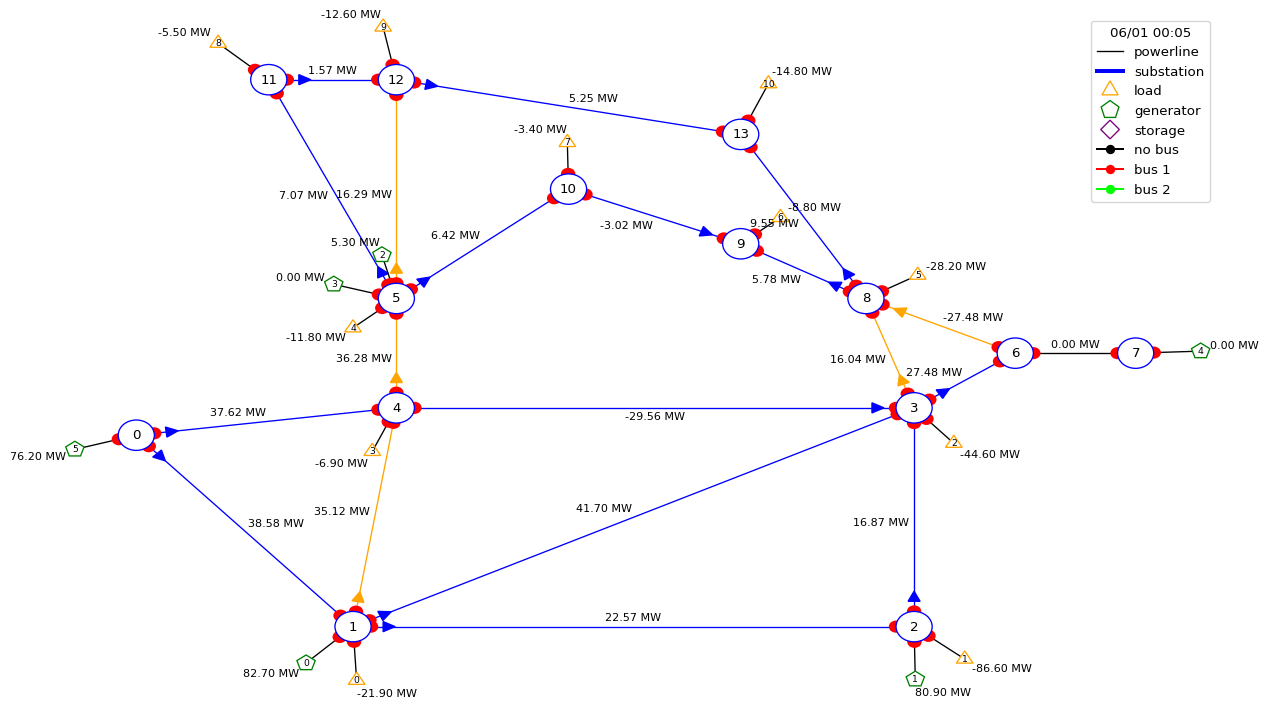

In [640]:
from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(env.observation_space)
init_obs, *_ = env.simulate(env.action_space())
#get_delta_theta_line(init_obs,id_l2)

print("when l1 and l2 are both connected")
print("delta theta l1: "+str(get_delta_theta_line(init_obs,id_l1)))
print("delta theta l2: "+str(get_delta_theta_line(init_obs,id_l2)))
fig = plot_helper.plot_obs(init_obs,line_info="p")
fig.show()


when l1 and l2 are disconnected
delta theta l1: -0.16183546892600587
delta theta l1: 0.41050156737560695


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/2986498964.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


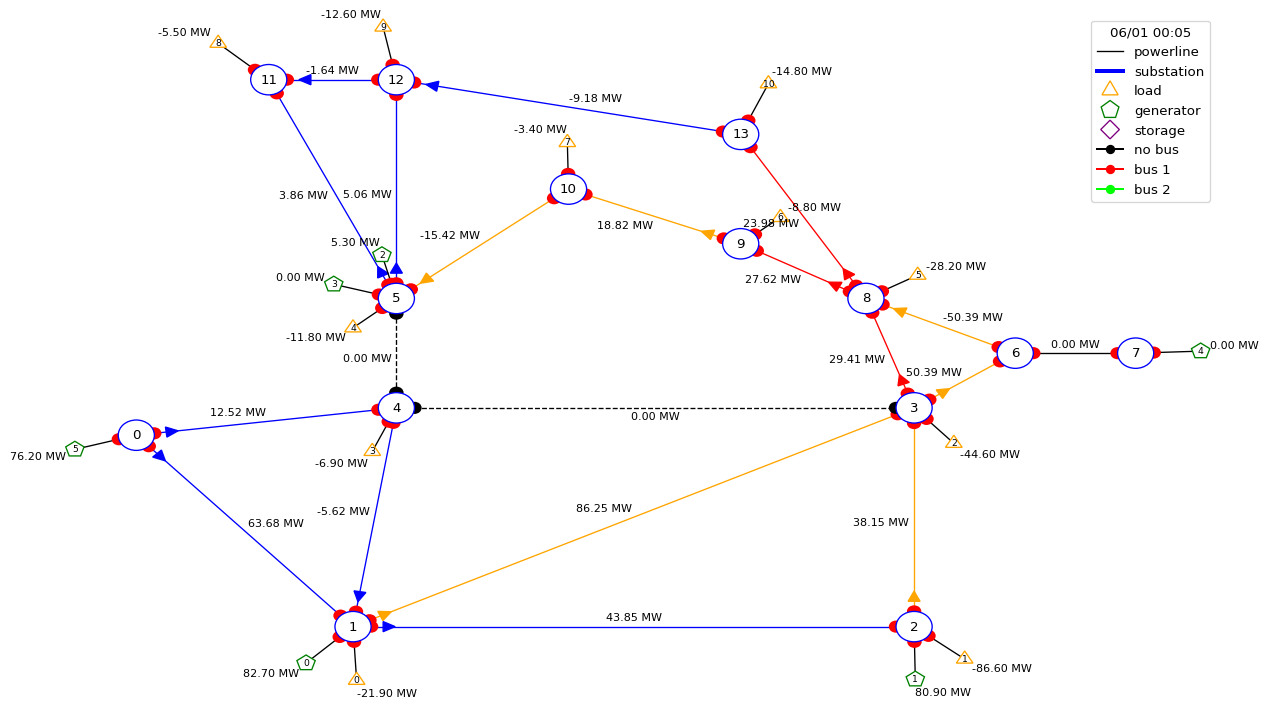

In [641]:
print("when l1 and l2 are disconnected")
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnected_l1_l2,id_l1)))
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnected_l1_l2,id_l2)))
fig = plot_helper.plot_obs(obs_disconnected_l1_l2,line_info="p")
fig.show()


when l1 is reconnected
delta theta l1: -0.025333248537010616
delta theta l1: 0.2739993636313544


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/1486352159.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


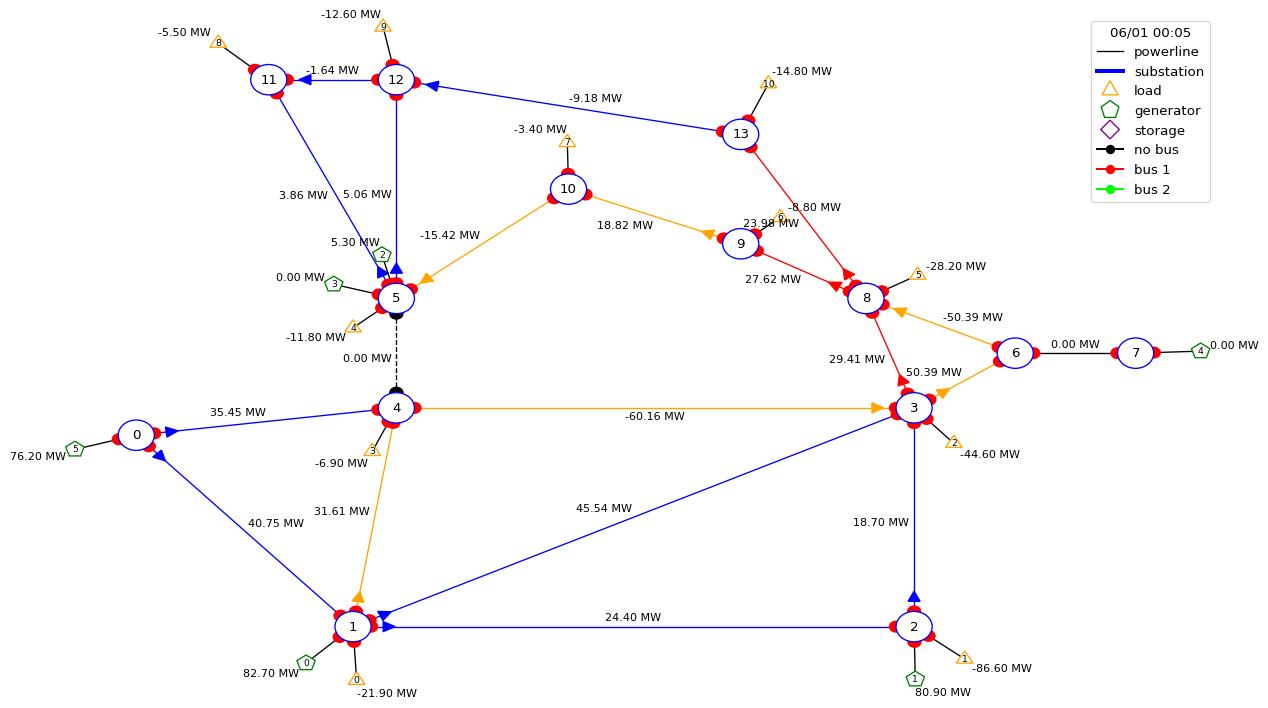

In [642]:
print("when l1 is reconnected")
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnect_l2,id_l1)))
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnect_l2,id_l2)))
fig = plot_helper.plot_obs(obs_disconnect_l2,line_info="p")
fig.show()


when l2 is reconnected
delta theta l1: -0.06345027952558464
delta theta l1: 0.10184660097519557


/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_8737/2728517373.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


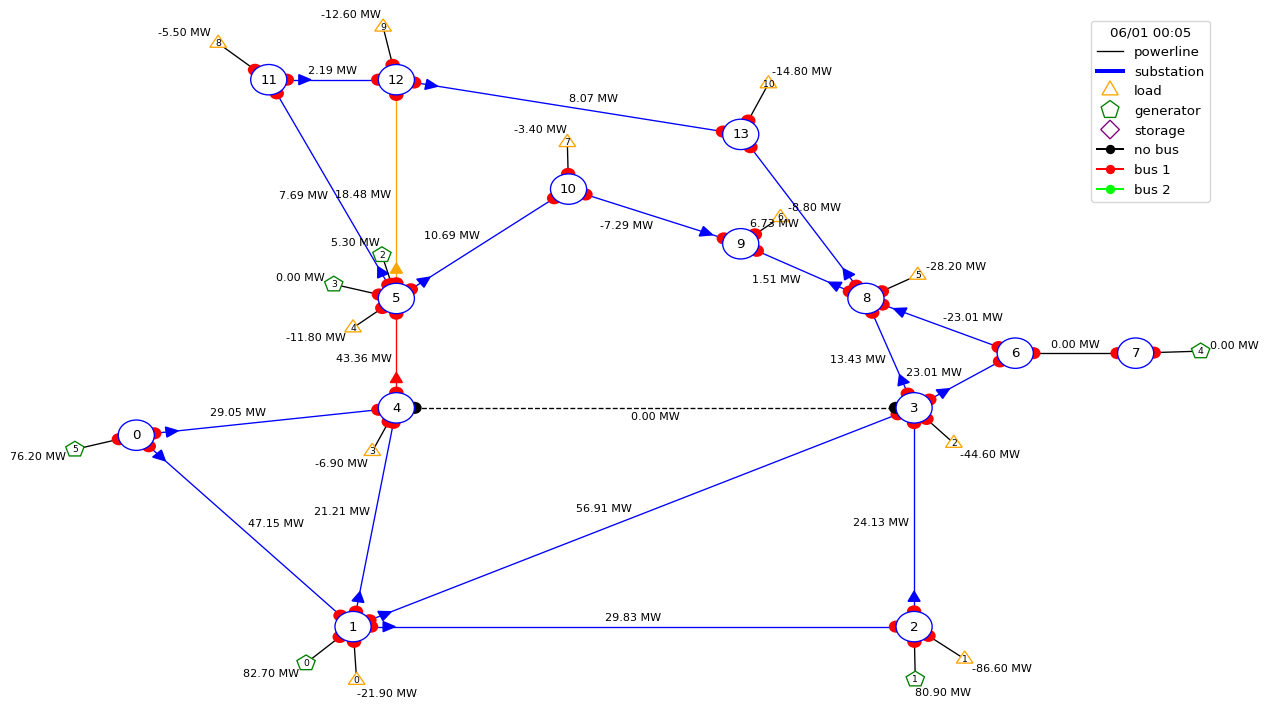

In [643]:
print("when l2 is reconnected")
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnect_l1,id_l1)))
print("delta theta l1: "+str(get_delta_theta_line(obs_disconnect_l1,id_l2)))
fig = plot_helper.plot_obs(obs_disconnect_l1,line_info="p")
fig.show()


## compute virtual flows for disconnections without using LODF


### compute Equivalent Resistance Matrix to see if we can use it to deduce virtual flows

In [18]:
YBus=env.backend._grid.get_dcYbus().todense()

In [19]:
pinv_Bbus=np.linalg.pinv(YBus)
n_nodes=pinv_Bbus.shape[0]
R_eq=np.array([[pinv_Bbus[i,i]+pinv_Bbus[j,j]-2*pinv_Bbus[i,j] for i in range(n_nodes)] for j in range(n_nodes)])

### Checking that for two lines disconnections P_fict and PN-1 are tied by an equation


In [20]:
# Inj1_fict/P1_N-1 = Inj2_fict/P2_N-1 

In [21]:
#id_l1=3
#id_l2=6
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
p_end,pls_virtual=get_Virtual_Flows_NK(por_init,A,[id_l1,id_l2])#[id_l1,id_l2,id_l3])
print(pls_virtual)

[42.17226227  7.42411841]
[42.17226227  7.42411841]


In [22]:
obs_disconnect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))
obs_disconnect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))

In [23]:
print(obs_disconnect_l1.p_or[id_l2])
print(obs_disconnect_l2.p_or[id_l1])

7.412795
42.10794


In [24]:
assert(0.0==np.round(pls_virtual[0]/obs_disconnect_l2.p_or[id_l1]-pls_virtual[1]/obs_disconnect_l1.p_or[id_l2],10))

### Scenario 1: disconnecting 1 line and assessing virtual flow - easy scenario

In [25]:
#lines to disconnect
[id_l1,id_l2,id_l3]


[3, 7, 0]

In [26]:
# virtual flows when disconnecting the 3 lines
#id_l1=2
#id_l2=4
init_obs, *_ = env.simulate(env.action_space())
por_init=init_obs.p_or.copy()
p_end=get_Virtual_Flows_NK(por_init,A,[id_l1,id_l2])#[id_l1,id_l2,id_l3])
p_end

[42.17226227  7.42411841]


(array([ 2.7362656e+01,  4.8837345e+01,  3.4829128e+01, -9.7242046e-09,
         5.3333527e+01,  2.9129133e+01, -6.1824879e+01,  1.0504630e-07,
         7.8667388e+00,  1.9079252e+01,  1.2200000e+01,  5.9540105e+00,
         3.4000001e+00,  2.3667386e+00,  8.8459892e+00,  2.9271120e+01,
         1.7082891e+01,  3.3445988e+01,  0.0000000e+00, -2.9271120e+01],
       dtype=float32),
 array([42.17226227,  7.42411841]))

In [27]:
init_obs.p_or[[id_l1,id_l2]]#,id_l3]]

array([41.696144 ,  6.4211507], dtype=float32)

In [28]:
obs_disconnect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))
obs_disconnect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))

In [29]:
obs_disconnect_l1.p_or[id_l2]

7.412795

In [30]:
obs_disconnect_l2.p_or[id_l1]

42.10794

In [31]:
#por_virtual=por_init
#for i in range(len(ilds)):
# por_virtual+=A[ilds[i]]*pls_virtual[i]


In [32]:
p_virt_sum=42.17226227+7.42411841
coeff = [1,-p_virt_sum , obs_disconnect_l1.p_or[id_l2]*7.42411841]
np.roots(coeff)

array([48.46075098,  1.1356297 ])

#### check that we compute flows properly with thetas

In [33]:
sub_l1_ex=init_obs.line_ex_to_subid[id_l1]
sub_l1_or=init_obs.line_or_to_subid[id_l1]

sub_l2_ex=init_obs.line_ex_to_subid[id_l2]
sub_l2_or=init_obs.line_or_to_subid[id_l2]

virtual_flow_l1=np.abs(YBus[sub_l1_or,sub_l1_ex])*get_delta_theta_line(init_obs,id_l1)*100
virtual_flow_l2=np.abs(YBus[sub_l2_or,sub_l2_ex])*get_delta_theta_line(init_obs,id_l2)*100
print(virtual_flow_l1)
print(virtual_flow_l2)

assert(np.float16(np.round(virtual_flow_l1,2))==np.float16(np.round(init_obs.p_or[id_l1],2)))
assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(init_obs.p_or[id_l2],2)))

41.69610956652579
6.421146766039707


#### now computing on a state with a disconneted line l1 (id=3)

Explication: lorsque la ligne est deconnectee, un flux virtual_flow_NorNexl1_wo_l1 circule entre ces deux noeuds extremites etant donne les differences de potentiel et une resistance equivalente Req_l_line_disco.

Pour obtenir un modèle équivalent en reconnectant l1, il faut que ce flux global soit conservé entre ces 2 noeuds.
En reconnectant l1, le dit flux se réparti entre la ligne l1 et le reste en parallèle selon une proportion dictée par les résistances équivalentes. ce ratio est Req_l/Rl

En effet, ratio=conductance_l/conductance_or_ex=(1/Rl) / (1/Rl + 1/Req_l_line_disco) = (1/Rl) / (1/Req_l)= Req_l/Rl

In [34]:
#useful to find other lines connected at same node when theta is set to zero by grid2op
#for the disconnected lines of interest
print(init_obs.line_ex_to_subid)
print(init_obs.line_or_to_subid)

[ 1  4  2  3  4  3  4 10 11 12  9 13 10 12 13  6  8  5  7  6]
[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]


In [35]:
obs_disconnect_l1, *_ = env.simulate(env.action_space({"set_line_status": [(id_l1, -1)]}))

delta_theta_l1=get_delta_theta_line(obs_disconnect_l1,id_l1)
print(delta_theta_l1)


0.11742979197035895


In [36]:
def get_Virtual_Flows_NK_withReq(delta_theta_l,Req_l,R_l):
    Req_l_disco=1/(1/Req_l-1/R_l)
    ratio=(Req_l/R_l)
    virtual_Flow=1/Req_l_disco*delta_theta_l*100*ratio
    
    return virtual_Flow

#(R_l+Req_l_disco)/(Req_l_disco*R_l)=1/Req_l

#(R_l+Req_l_disco)=(Req_l_disco*R_l)/Req_l

In [37]:
def compute_Req_disconnected(YBus,obs,ids_l):
    YBus_disconnected=YBus.copy()
    for il in ids_l:
        sub_li_ex=obs.line_ex_to_subid[il]
        sub_li_or=obs.line_or_to_subid[il]
        YBus_disconnected[sub_li_or,sub_li_or]+=YBus_disconnected[sub_li_or,sub_li_ex]
        YBus_disconnected[sub_li_ex,sub_li_ex]+=YBus_disconnected[sub_li_or,sub_li_ex]
        YBus_disconnected[sub_li_or,sub_li_ex]=0
        YBus_disconnected[sub_li_ex,sub_li_or]=0
    
    pinv_Bbus_disconnected=np.linalg.pinv(YBus_disconnected)
    n_nodes=pinv_Bbus_disconnected.shape[0]
    R_eq_disconnected=np.array([[pinv_Bbus_disconnected[i,i]+pinv_Bbus_disconnected[j,j]-2*pinv_Bbus_disconnected[i,j] for i in range(n_nodes)] for j in range(n_nodes)])

    return R_eq_disconnected

In [38]:
#equivalent resistance between extremities of line l1 with l1 connected
Req_l1=R_eq[sub_l1_or][sub_l1_ex]
Req_l1

(0.0659323689293208+0j)

In [39]:
#resistence of l1 line
R_l1=np.abs(1/YBus[sub_l1_or,sub_l1_ex])
R_l1

0.17632

In [40]:
get_Virtual_Flows_NK_withReq(delta_theta_l1,Req_l1,R_l1)

(41.69611104220989+0j)

In [41]:
#equivalent resistance between extremities of line l1 with l1 disconnected
Req_l1_line_disco=1/(1/Req_l1-1/R_l1)
Req_l1_line_disco

(0.1053124809080688+0j)

In [42]:
virtual_flow_NorNexl1_wo_l1=np.abs(1/Req_l1_line_disco*100*get_delta_theta_line(obs_disconnect_l1,id_l1))
print(virtual_flow_NorNexl1_wo_l1)

111.50605413319225


In [43]:
#ratio of equivalent resistance with and without l1 line
#(0.0659/0.105)*67.407
virtual_flow_l1=(Req_l1/R_l1)*virtual_flow_NorNexl1_wo_l1
virtual_flow_l1

(41.69611104220989+0j)

In [44]:
#flow for a line of resistance Req_l1_line_disco+R_l1
1/(Req_l1_line_disco+R_l1)*100*(delta_theta_l1)

(41.69611104220989+0j)

In [45]:
assert(np.float16(np.round(virtual_flow_l1,2))==np.float16(np.round(init_obs.p_or[id_l1],2)))

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_16611/2669778609.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l1,2))==np.float16(np.round(init_obs.p_or[id_l1],2)))


#### now computing on a state with a disconneted line l2 (id=7)

In [46]:
#useful to find other lines connected at same node when theta is set to zero by grid2op
#for the disconnected lines of interest
print(init_obs.line_ex_to_subid)
print(init_obs.line_or_to_subid)

[ 1  4  2  3  4  3  4 10 11 12  9 13 10 12 13  6  8  5  7  6]
[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]


In [47]:
obs_disconnect_l2, *_ = env.simulate(env.action_space({"set_line_status": [(id_l2, -1)]}))

delta_theta_l2=get_delta_theta_line(obs_disconnect_l2,id_l2)#theta_or[id_l1]-theta_ex[id_l1] #be careful for disconnected lines, thetas are set to 0. 
#should find connected lines with same node extremity to get the theta
#look at id_l=12 (same sub_ex) and in theta_ex
#look at id_l=8  (same sub_or) and in theta_or
print(delta_theta_l2)



0.048764369161605835


In [48]:
#equivalent resistance between extremities of line l2 but with l2 disconnected
Req_l2=R_eq[sub_l2_or][sub_l2_ex]
Req_l2


(0.1468069814688445+0j)

In [49]:
#resistence of l2 line
R_l2=np.abs(1/YBus[sub_l2_or,sub_l2_ex])
R_l2

0.1989

In [50]:
sub_l2_ex

10

In [51]:
#equivalent resistance between extremities of line l2 with l2 connected
Req_l2_line_disco=1/(1/Req_l2-1/R_l2)
Req_l2_line_disco

(0.5605340108423444+0j)

In [52]:
virtual_flow_NorNexl2_wo_l2=np.abs(1/Req_l2_line_disco*100*get_delta_theta_line(obs_disconnect_l2,id_l2))
print(virtual_flow_NorNexl2_wo_l2)

8.699627180217844


In [53]:
#ratio of equivalent resistance with and without l2 line with virtual flow
#(0.0659/0.105)*67.407
virtual_flow_l2=(Req_l2/R_l2)*virtual_flow_NorNexl2_wo_l2
virtual_flow_l2

(6.4211463360085315+0j)

In [54]:
get_Virtual_Flows_NK_withReq(delta_theta_l2,Req_l2,R_l2)

(6.4211463360085315+0j)

In [55]:
assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(init_obs.p_or[id_l2],2)))

/var/folders/q5/5kqzvjn503q60db2flx6x4yr0000gn/T/ipykernel_16611/2971103753.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  assert(np.float16(np.round(virtual_flow_l2,2))==np.float16(np.round(init_obs.p_or[id_l2],2)))


In [94]:
YBus_l1_l2_disconnected=YBus.copy()

In [95]:
YBus_l1_l2_disconnected[sub_l1_or,sub_l1_or]+=YBus_l1_l2_disconnected[sub_l1_or,sub_l1_ex]
YBus_l1_l2_disconnected[sub_l1_ex,sub_l1_ex]+=YBus_l1_l2_disconnected[sub_l1_or,sub_l1_ex]
YBus_l1_l2_disconnected[sub_l1_or,sub_l1_ex]=0
YBus_l1_l2_disconnected[sub_l1_ex,sub_l1_or]=0

In [96]:
YBus_l1_l2_disconnected[sub_l2_or,sub_l2_or]+=YBus_l1_l2_disconnected[sub_l2_or,sub_l2_ex]
YBus_l1_l2_disconnected[sub_l2_ex,sub_l2_ex]+=YBus_l1_l2_disconnected[sub_l2_or,sub_l2_ex]
YBus_l1_l2_disconnected[sub_l2_or,sub_l2_ex]=0
YBus_l1_l2_disconnected[sub_l2_ex,sub_l2_or]=0

In [97]:
pinv_Bbus_disconnected=np.linalg.pinv(YBus_l1_l2_disconnected)
n_nodes=pinv_Bbus_disconnected.shape[0]
R_eq_disconnected=np.array([[pinv_Bbus_disconnected[i,i]+pinv_Bbus_disconnected[j,j]-2*pinv_Bbus_disconnected[i,j] for i in range(n_nodes)] for j in range(n_nodes)])

### check a relation between R_eq_l1_disco and R_eq_l2_disco

In [684]:
#(Req_l1_disco - Req_l1_all_disconnected )*(r_l2_connect+Req_l2_all_disconnected) =
#	(Req_l2_disco-Req_l2_all_disconnected)*(r_l1_connect+Req_l1_all_disconnected)


In [685]:
R_eq_l1_l2_disconnected=compute_Req_disconnected(YBus,init_obs,[id_l1,id_l2])

R_eq_l1_disconnected=compute_Req_disconnected(YBus,init_obs,[id_l1])

R_eq_l2_disconnected=compute_Req_disconnected(YBus,init_obs,[id_l2])

In [686]:
#1/Req_disco*delta_thetas_line_disconnected=(1/Req_disco+1/Rl)*delta_thetas_line_connected
def compute_Req_line_all_disconected(obs_all_disconnected,obs_line_reconnected,id_l,r_l):
    delta_thetas_line_disconnected=get_delta_theta_line(obs_all_disconnected,id_l)
    delta_thetas_line_connected=get_delta_theta_line(obs_line_reconnected,id_l)
    Req_disco=r_l*(delta_thetas_line_disconnected-delta_thetas_line_connected)/delta_thetas_line_connected
    
    return Req_disco


In [687]:
obs_reco_l1=obs_disconnect_l2
R_l1=np.abs(1/YBus[sub_l1_or,sub_l1_ex])
compute_Req_line_all_disconected(obs_disconnected_l1_l2,obs_reco_l1,id_l1,R_l1)

0.2849620084824754

In [688]:
R_eq_l1_l2_disconnected[sub_l1_or,sub_l1_ex]

(0.2849619766653643+0j)

In [689]:
obs_reco_l2=obs_disconnect_l1
R_l2=np.abs(1/YBus[sub_l2_or,sub_l2_ex])
compute_Req_line_all_disconected(obs_disconnected_l1_l2,obs_reco_l2,id_l2,R_l2)

0.12238566888131468

In [690]:
R_eq_l1_l2_disconnected[sub_l2_or,sub_l2_ex]

(0.1223856786257417+0j)

Now checking the relation

In [691]:
Req_l1_disco=R_eq_l1_disconnected[sub_l1_or,sub_l1_ex]
Req_l2_disco=R_eq_l2_disconnected[sub_l2_or,sub_l2_ex]

In [692]:
ratio1=(Req_l1_disco-R_eq_l1_l2_disconnected[sub_l1_or,sub_l1_ex])*\
(R_l2+R_eq_l1_l2_disconnected[sub_l2_or,sub_l2_ex])
ratio1

(-0.009971123491339403+0j)

In [693]:
ratio2=(Req_l2_disco-R_eq_l1_l2_disconnected[sub_l2_or,sub_l2_ex])*\
(R_l1+R_eq_l1_l2_disconnected[sub_l1_or,sub_l1_ex])
ratio2

(-0.009971123491339478+0j)

In [694]:
assert(np.round(ratio1,8)==np.round(ratio2,8))

In [695]:
#Req_l1_disco=
print(Req_l1_disco)
(Req_l2_disco-R_eq_l1_l2_disconnected[sub_l2_or,sub_l2_ex])*\
(R_l1+R_eq_l1_l2_disconnected[sub_l1_or,sub_l1_ex])/(R_l2+R_eq_l1_l2_disconnected[sub_l2_or,sub_l2_ex])\
+R_eq_l1_l2_disconnected[sub_l1_or,sub_l1_ex]
                         


(0.2513059570494862+0j)


(0.25130595704948594+0j)

In [696]:
#1/(R_l2+Req_l2_disco)*delta_thetas_all_discos_l2 / Pl2_n-1   = 1/(R_l1+Req_l1_disco)*delta_thetas_all_discos_l1 /Pl1_n-1



In [697]:
# pls_virtual[0]=delta_thetas_all_discos_l1/(R_l1+Req_l1_disco)*
p_end,pls_virtual=get_Virtual_Flows_NK(por_init,A,[id_l1,id_l2])
print(pls_virtual[0])
delta_thetas_all_discos_l1=get_delta_theta_line(obs_disconnected_l1_l2,id_l1)

delta_thetas_all_discos_l1/(R_l1+R_eq_l1_disconnected[sub_l1_or,sub_l1_ex])

[32.06222852 45.9282483 ]
32.062228524853765


(0.32062205724864945+0j)

In [698]:
Pl2_n_1=obs_disconnect_l1.p_or[id_l2]
Pl1_n_1=obs_disconnect_l2.p_or[id_l1]

delta_thetas_all_discos_l1=get_delta_theta_line(obs_disconnected_l1_l2,id_l1)
delta_thetas_all_discos_l2=get_delta_theta_line(obs_disconnected_l1_l2,id_l2)

left_hs=1/(R_l2+R_eq_l2_disconnected[sub_l2_or,sub_l2_ex])*delta_thetas_all_discos_l2/Pl2_n_1
right_hs=1/(R_l1+R_eq_l1_disconnected[sub_l1_or,sub_l1_ex])*delta_thetas_all_discos_l1/Pl1_n_1
print(left_hs)
print(right_hs)
assert(np.round(left_hs,7)==np.round(right_hs,7))

(0.010749107517608733+0j)
(0.010749109042712758+0j)


one more check of derivation

In [699]:
Req_l2_disco=R_eq_l2_disconnected[sub_l2_or,sub_l2_ex]
print(Req_l2_disco)

(0.10173862278116938+0j)


In [700]:
Req_l1_disco=R_eq_l1_disconnected[sub_l1_or,sub_l1_ex]
(R_l1+Req_l1_disco)*delta_thetas_all_discos_l2/delta_thetas_all_discos_l1*Pl1_n_1/Pl2_n_1-R_l2

(0.10173858367587521+0j)

In [701]:
#Req_l1_disco=
#print(Req_l1_disco)
#(Req_l2_disco-R_eq_l1_l2_disconnected[sub_l2_or,sub_l2_ex])*\
#(R_l1+R_eq_l1_l2_disconnected[sub_l1_or,sub_l1_ex])/(R_l2+R_eq_l1_l2_disconnected[sub_l2_or,sub_l2_ex])\
#+R_eq_l1_l2_disconnected[sub_l1_or,sub_l1_ex]

# RF=(R_l1+R_eq_l1_l2_disconnected[sub_l1_or,sub_l1_ex])/(R_l2+R_eq_l1_l2_disconnected[sub_l2_or,sub_l2_ex])

#Req_l1_disco=(Req_l2_disco-Req_l2_all_disconnected)*RF + Req_l1_all_disconnected



In [702]:
# RF=(r_l1_connect+Req_l1_all_disconnected)/(r_l2_connect+Req_l2_all_disconnected)
RF=(R_l1+R_eq_l1_l2_disconnected[sub_l1_or,sub_l1_ex])/(R_l2+R_eq_l1_l2_disconnected[sub_l2_or,sub_l2_ex])
print(RF)
print(Req_l1_disco)
(Req_l2_disco-R_eq_l1_l2_disconnected[sub_l2_or,sub_l2_ex])*RF + R_eq_l1_l2_disconnected[sub_l1_or,sub_l1_ex]

(1.6300638633050346+0j)
(0.2513059570494862+0j)


(0.251305957049486+0j)

In [703]:
# D = delta_thetas_all_discos_l2 *Pl1_n-1/Pl2_n-1 / delta_thetas_all_discos_l1
#Req_l2_disco = (R_l1+Req_l1_disco)*D - R_l2
#Req_l2_disco = (R_l1+(Req_l2_disco-Req_l2_all_disconnected)*RF + Req_l1_all_disconnected)*D - R_l2

#(R_l1+(Req_l2_disco-Req_l2_all_disconnected)*RF + Req_l1_all_disconnected)*D - R_l2
#if RF*D=1
#(R_l1+Req_l2_disco-Req_l2_all_disconnected + Req_l1_all_disconnected*D - R_l2
# R_l1-Req_l2_all_disconnected + Req_l1_all_disconnected*D - R_l2 =0

In [704]:
# Req_l2_disco = (R_l1*D - Req_l2_all_disconnected *RF*D + Req_l1_all_disconnected*D - Rl2) / (1 -RF*D)
print(Req_l2_disco)
(R_l1+(Req_l2_disco-R_eq_l1_l2_disconnected[sub_l2_or,sub_l2_ex])*RF + R_eq_l1_l2_disconnected[sub_l1_or,sub_l1_ex])*D - R_l2

#R_l1+Req_l2_disco-


(0.10173862278116938+0j)


(1.0376114844167363+0j)

In [705]:
#D = delta_thetas_all_discos_l2 *Pl1_n-1/Pl2_n-1 / delta_thetas_all_discos_l1
Pl2_n_1=obs_disconnect_l1.p_or[id_l2]
Pl1_n_1=obs_disconnect_l2.p_or[id_l1]

delta_thetas_all_discos_l1=get_delta_theta_line(obs_disconnected_l1_l2,id_l1)
delta_thetas_all_discos_l2=get_delta_theta_line(obs_disconnected_l1_l2,id_l2)
D=delta_thetas_all_discos_l2/delta_thetas_all_discos_l1*Pl1_n_1/Pl2_n_1
D

0.6134728096422859

In [706]:
print(Req_l2_disco)
(R_l1+Req_l1_disco)*D - R_l2

(0.10173862278116938+0j)


(0.10173858367587527+0j)

In [707]:
RF*D

(0.9999998581180987+0j)

In [708]:
# Req_l2_disco = (R_l1*D - Req_l2_all_disconnected *RF*D + Req_l1_all_disconnected*D - Rl2) / (1 -RF*D)
# Req_l2_disco = (R_l1*D - Req_l2_all_disconnected *RF*D + Req_l1_all_disconnected*D - Rl2) / (1 -RF*D)
(R_l1*D - R_eq_l1_l2_disconnected[sub_l2_or,sub_l2_ex]*RF*D + R_eq_l1_l2_disconnected[sub_l1_or,sub_l1_ex]*D - R_l2)\
/(1 -RF*D)


(-0.17388000022122782+0j)

In [709]:
(R_l1*D - R_eq_l1_l2_disconnected[sub_l2_or,sub_l2_ex]*RF*D + R_eq_l1_l2_disconnected[sub_l1_or,sub_l1_ex]*D - R_l2)

(-2.4670425036177335e-08+0j)

In [710]:
R_eq_l2_disconnected[sub_l2_or,sub_l2_ex]

(0.10173862278116938+0j)

In [711]:
RF*D

(0.9999998581180987+0j)

In [712]:
#pls_virtual[0]/obs_disconnect_l2.p_or[id_l1] = pls_virtual[1]/obs_disconnect_l1.p_or[id_l2]
#Pl2_n_1=obs_disconnect_l1.p_or[id_l2]
#Pl1_n_1=obs_disconnect_l2.p_or[id_l1]

In [713]:
Req_l1_disco_proxy=delta_thetas_all_discos_l1/Pl1_n_1 - R_l1
Req_l2_disco_proxy=delta_thetas_all_discos_l2/Pl2_n_1 - R_l2
print(Req_l1_disco_proxy)
print(Req_l2_disco_proxy)

-0.19314068374740595
-0.17091734578986997


In [714]:
Req_l1_disco_proxy/Req_l2_disco_proxy

1.130023888768188

In [715]:
ratio1=(Req_l1_disco_proxy-R_eq_l1_l2_disconnected[sub_l1_or,sub_l1_ex])*\
(R_l2+R_eq_l1_l2_disconnected[sub_l2_or,sub_l2_ex])
ratio1

(-0.14164540913996193+0j)

In [716]:
ratio2=(Req_l2_disco_proxy-R_eq_l1_l2_disconnected[sub_l2_or,sub_l2_ex])*\
(R_l1+R_eq_l1_l2_disconnected[sub_l1_or,sub_l1_ex])
ratio2

(-0.14164540934296097+0j)

In [717]:
#alpha=1-np.sum(betas)
beta_l1=1
beta_l2=1
alpha=1-(beta_l1+beta_l2)
res_flow=beta_l1*obs_disconnect_l2.p_or+beta_l2*obs_disconnect_l1.p_or+alpha*obs_disconnected_l1_l2.p_or
res_flow

array([ 44.451527 ,  31.748466 ,  29.82778  ,  32.69628  ,  42.727463 ,
        24.127783 , -31.204575 ,   6.478985 ,   7.0767026,  16.315674 ,
         5.7210155,   9.507624 ,  -3.078985 ,   1.5767032,   5.292378 ,
        27.42384  ,  16.0048   ,  36.371365 ,   0.       , -27.42384  ],
      dtype=float32)

In [718]:
sub_ors=obs_disconnected_l1_l2.line_or_to_subid
sub_exs=obs_disconnected_l1_l2.line_ex_to_subid

In [719]:
print(id_l1)
print(id_l2)

2
4


In [720]:
print(res_flow[id_l1])
print(obs_disconnect_l2.p_or[id_l1])

29.82778
29.82778


In [721]:
np.abs(1/YBus[sub_ors[id_l2],sub_exs[id_l2]])

0.17388

In [722]:
delta_thetas_proxy=[res_flow[i]*np.abs(1/YBus[sub_ors[i],sub_exs[i]]) for i in range(env.n_line)]
delta_thetas_proxy

[2.63019683139801,
 7.081177966308594,
 5.9050055610466,
 5.765008342285157,
 7.4294512261962895,
 4.126574695987701,
 -1.3140246357727052,
 1.2886700832366942,
 1.8102912907648085,
 2.1254428295898435,
 0.4834258058071137,
 2.5706712885665897,
 -0.5913806443047523,
 0.31515143377780913,
 1.8418533737277984,
 5.60870611741333,
 8.625602053685189,
 8.543002136125184,
 0.0,
 -3.0168965909957888]

In [723]:
#if beta_l1=1=beta_l2
#delta_theta_1_4=delta_theta_1_4_l2_disco and delta_theta_1_2=delta_theta_1_2_l1_disco don't change
#delta_theta_1_4 = delta_theta_1_2 + delta_theta_2_3 + delta_theta_3_4 
#hence delta_theta_2_3 + delta_theta_3_4 = delta_theta_1_4_l2_disco + delta_theta_1_2_l1_disco  should not change either


In [724]:
print(sub_ors)
print(sub_exs)

[ 0  0  1  1  1  2  3  5  5  5  8  8  9 11 12  3  3  4  6  8]
[ 1  4  2  3  4  3  4 10 11 12  9 13 10 12 13  6  8  5  7  6]


In [725]:
print(get_delta_theta_line(obs_disconnected_l1_l2,id_l1))#delta_theta_1_4
print(get_delta_theta_line(obs_disconnected_l1_l2,id_l2))#delta_theta_1_2
print(get_delta_theta_line(obs_disconnected_l1_l2,5))#delta_theta_2_3
print(get_delta_theta_line(obs_disconnected_l1_l2,6))#delta_theta_3_4

get_delta_theta_line(obs_disconnected_l1_l2,id_l2)-get_delta_theta_line(obs_disconnected_l1_l2,5)-get_delta_theta_line(obs_disconnected_l1_l2,6)



0.14404778162156212
0.1265866974594328
-0.009748709317684174
-0.007712366522073746


0.14404777329919072

In [726]:
print(get_delta_theta_line(obs_disconnect_l2,id_l1)*100)
print(get_delta_theta_line(obs_disconnect_l1,id_l2)*100)

5.905000875222683
7.429445010405115


In [727]:
#virtual_flow_l2=np.abs(YBus[sub_l2_or,sub_l2_ex])*get_delta_theta_line(init_obs,id_l2)*100
#print(delta_thetas_proxy[id_l1])
#print(delta_thetas_proxy[id_l2])
print(delta_thetas_proxy[id_l2]-delta_thetas_proxy[id_l1])
print(delta_thetas_proxy[5]+delta_thetas_proxy[6])

1.5244456651496892
2.8125500602149955


In [728]:
#print(get_delta_theta_line(init_obs,id_l1))#delta_theta_1_4
#print(get_delta_theta_line(init_obs,id_l2))#delta_theta_1_2
#print(get_delta_theta_line(init_obs,5))#delta_theta_2_3
#print(get_delta_theta_line(init_obs,6))#delta_theta_3_4

print(get_delta_theta_line(init_obs,id_l2)-get_delta_theta_line(init_obs,id_l1))
print(get_delta_theta_line(init_obs,5)+get_delta_theta_line(init_obs,6))


0.016396440642555556
0.016396440642555556
